## All experiments vs Cascadia to determine look back/forward and down-sampling

### Imports

In [1]:
# Set Directories

jasmin = True  # Set to True if running on JASMIN, False if on local machine
jasmin_user_name = "trr26"

if jasmin:
    MAIN_DIR = f"/gws/nopw/j04/ai4er/users/{jasmin_user_name}/earthquake-predictability"
    DATA_DIR = f"{MAIN_DIR}/data/gtc_quakes_data"

else:  # update directory names to match your local machine
    MAIN_DIR = f"/home/tom-ratsakatika/VSCode/earthquake-predictability"
    DATA_DIR = f"{MAIN_DIR}/data_local"

# Imports
import os
import random
import sys
sys.path.append(MAIN_DIR)

# Import relevant libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Import local modules - note: dependent on above path being set.
from utils.dataset import SlowEarthquakeDataset
from utils.data_preprocessing import moving_average_causal_filter, compare_feature_statistics

### Efficiently load all the experiments and store them in a dataframe

In [2]:
EXPERIMENTS = [
    "cascadia",
    "p4679",
    "p4581",
    "b726",
    "b698",
    "i417",
    "sim_b726",
    "sim_b698",
    "sim_i417",
]

# Initialize the dataset loader with all experiments and load the data
dataset_loader = SlowEarthquakeDataset(EXPERIMENTS)
dataset_loader.load()

df = {
    exp: dataset_loader.convert_to_df(exp)
    .rename(columns={"seg_avg" if exp == "cascadia" else "obs_shear_stress": "X"})[["X"]]
    for exp in EXPERIMENTS
}

### Determine experiment down-sampling required to match Cascadia

**Each time step should represent the same amount of "movement" for all of our datasets.** I.e. if it takes 30 time steps to go from a peak to a trough in Cascadia, it should take 30 time steps to do the same in our experiments. This is important because our models are trained to predict a fixed number of steps forward. This fixed look forward must represent the same "movement" in the sim, experiments and Cascadia to enable transfer learning.

**How much "movement" is covered in each time step is controlled by adjusting the down-sampling factor.** The following code filters each experiment with a bespoke down-sampling factor. It then displays the impact of this by truncating all the same length as Cascadia and plotting horizontally for comparison. A black dotted line is plotted every 30 timesteps for each dataset. Note: Cascadia has 10 troughs; the down-sampling has been tuned for each experiment to approximately match this for the same number of data points.

**Conclusion: we should have a look forward of 60 time steps.**  This is 60 days/2 months in the Cascadia data set. This is longer than Adriano's work suggests is possible (his paper shows the deterministic forecasting horizon is in the region of days/weeks). However, as the Cascadia data is noisy, it is difficult to pinpoint when a slowquake starts to within 60 time steps, when visually inspecting the ground truth. It would therefore not be sensible to forecast and plot a shorter time horizon (e.g. 30 steps / 1 month) because the forecast would be indistinguishable from the background noise.

**Regarding the look back**, we could decide to tune this as a hyperparameter. If a specific number is preferred, we are only limited by the amount of data in nature that we have (over 3500 points) and processing limitations. A look back of 600 (10x look forward) would span approximately one cycle, so information about the previous peak would be included. A look back of 180 (x3 look forward) would provide enough contextual information to tell the model where in the cycle it is. This is a matter for debate within the group.

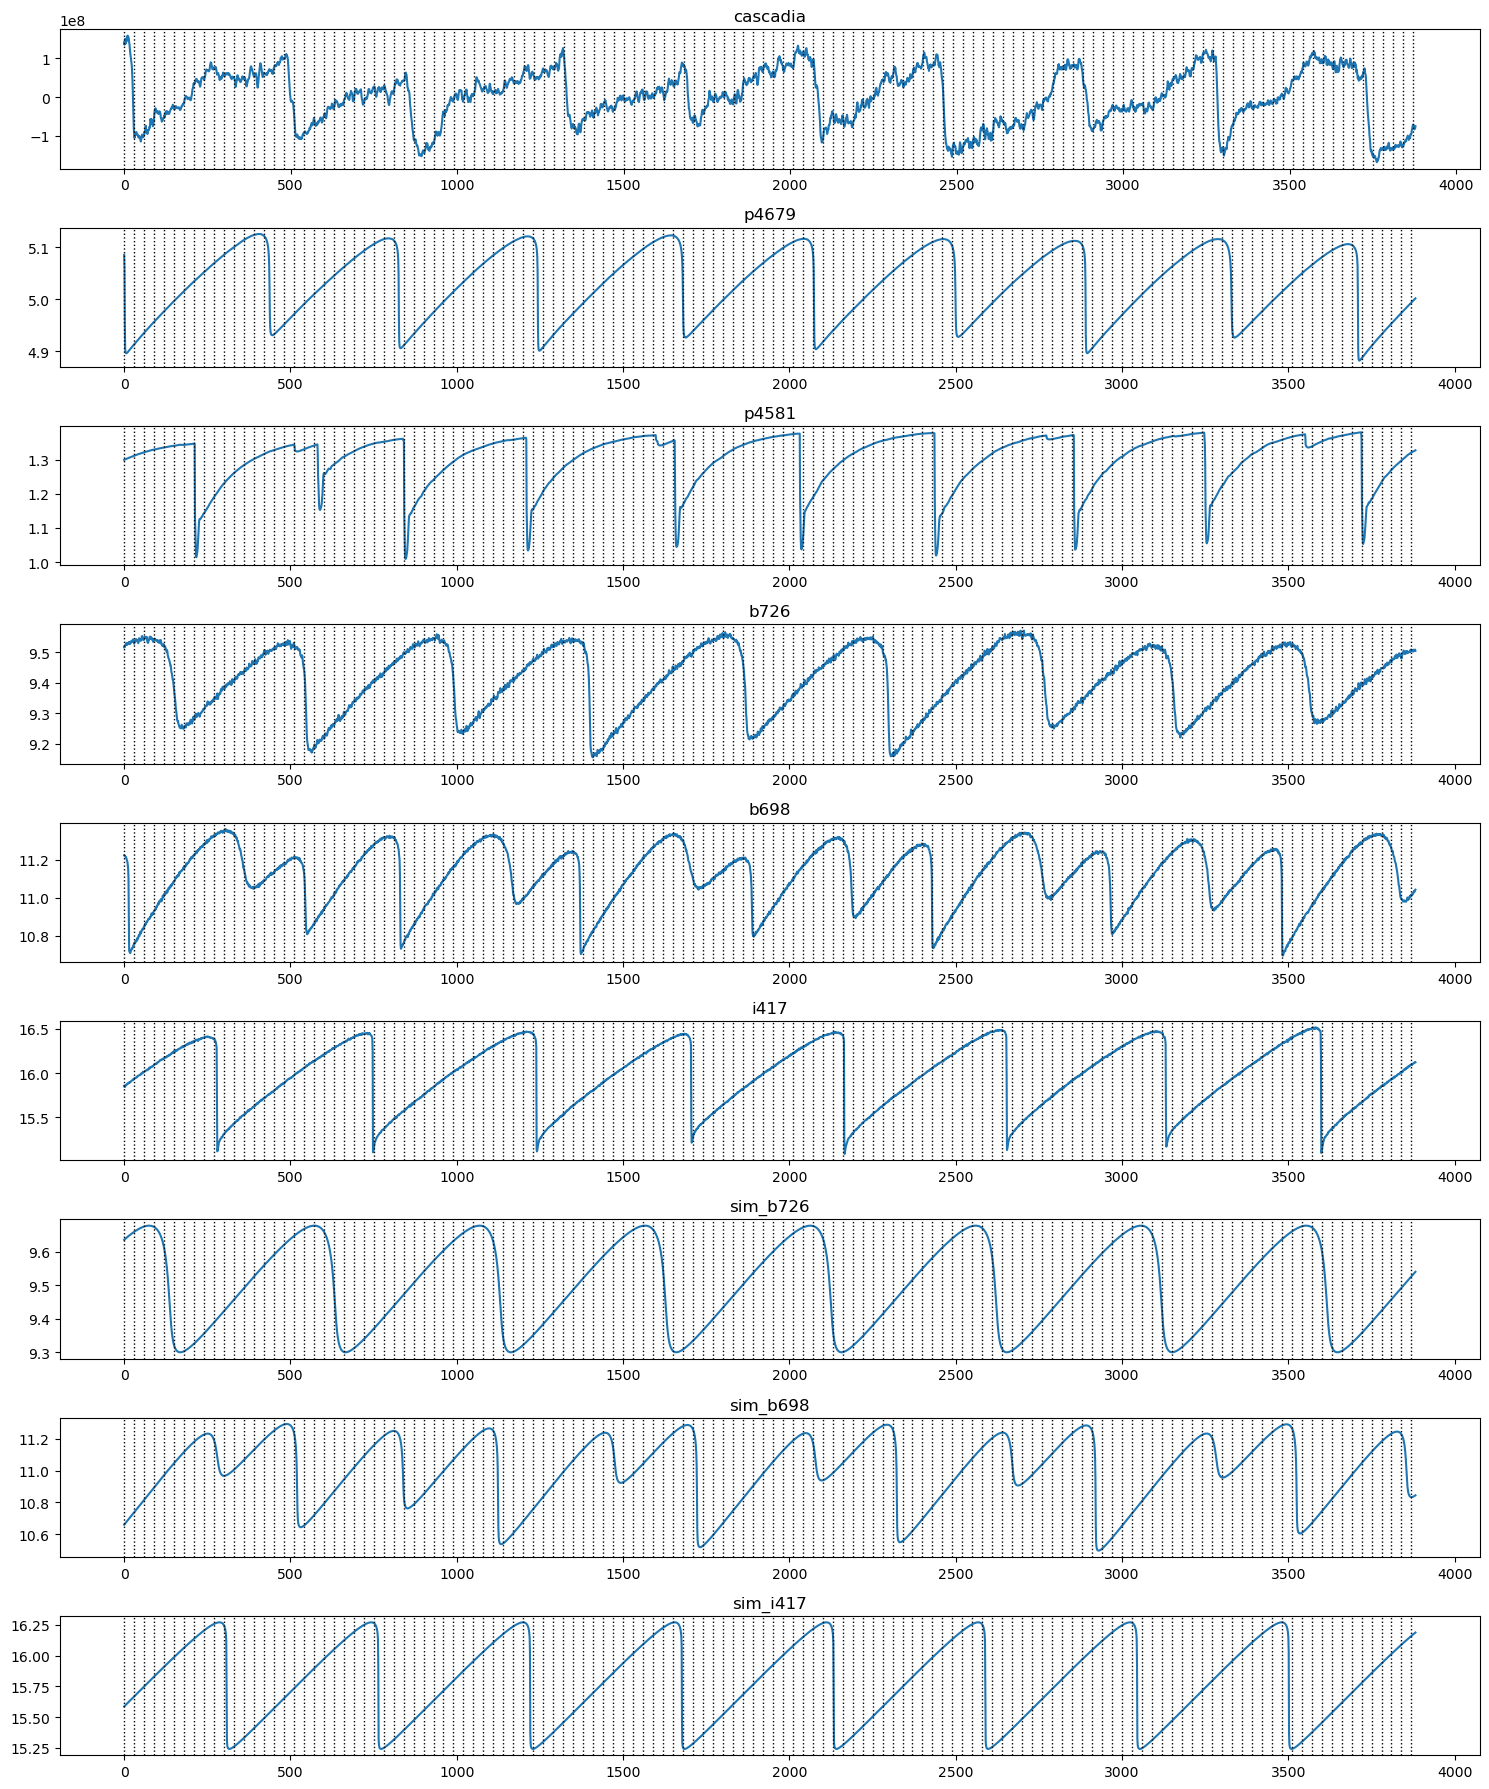

In [3]:
# Define smoothing window and downsampling factor for each experiment (must be integers)
settings = {
    "cascadia": {"smoothing_window": 5, "downsampling_factor": 1},
    "p4679": {"smoothing_window": 13, "downsampling_factor": 13},
    "p4581": {"smoothing_window": 26, "downsampling_factor": 26},
    "b726": {"smoothing_window": 1, "downsampling_factor": 1},
    "b698": {"smoothing_window": 2, "downsampling_factor": 2},
    "i417": {"smoothing_window": 2, "downsampling_factor": 2},
    "sim_b726": {"smoothing_window": 1, "downsampling_factor": 1},
    "sim_b698": {"smoothing_window": 2, "downsampling_factor": 2},
    "sim_i417": {"smoothing_window": 2, "downsampling_factor": 2},
}

# Apply function to every DataFrame in df
df_filtered = {
    exp: moving_average_causal_filter(df[exp], **settings[exp])
    for exp in df
}

# Truncate length of all dataframes to match the length of 'cascadia' dataframe
cascadia_length = len(df["cascadia"])

df_truncated = {exp: df_exp.head(cascadia_length) for exp, df_exp in df_filtered.items()}

# Sort experiments to start with 'cascadia', then plot all data
sorted_experiments = ['cascadia'] + [exp for exp in EXPERIMENTS if exp != 'cascadia']

plt.figure(figsize=(15, len(sorted_experiments) * 2))
for i, exp in enumerate(sorted_experiments, 1):
    plt.subplot(len(sorted_experiments), 1, i)
    data = df_truncated[exp].reset_index()  # Reset index to ensure 'id' column exists
    sns.lineplot(data=data, x=data.index, y="X")  # Use the DataFrame index for x
    for x in np.arange(0, len(data), 30):
        plt.axvline(x=x, color='black', linestyle=':', linewidth=1)
    plt.title(exp)
    plt.ylabel('')
    plt.xlabel('')

plt.tight_layout()
plt.show()


### Statistical comparison - raw vs smoothed data

_Source: ChatGPT_

"The following function conducts a statistical comparison between the raw and smoothed (downsampled) data sets to evaluate differences in their mean values and variances. It uses the Mann-Whitney U test to compare the means, which is suitable for non-parametric data (data that doesn't necessarily follow a normal distribution), and Levene's test to compare variances, ensuring we can assess the equality of variances between the two data sets regardless of their distribution shapes. The results are presented in terms of statistics and p-values, with a significance level set at 0.05 to determine if the observed differences are statistically significant. This approach allows us to understand whether the smoothing process affects the fundamental statistical properties of the data, providing insights into the impact of data preprocessing techniques on data analysis."

In [4]:
from scipy.stats import ttest_ind, levene, mannwhitneyu, f_oneway
import numpy as np

def compare_feature_statistics(original_feature, downsampled_feature, significance_level=0.05):
    """
    Compare the mean and variance of two samples using appropriate statistical tests.

    Parameters:
        original_feature (pd.Series): The original feature for comparison.
        downsampled_feature (pd.Series): The downsampled feature for comparison.
        significance_level (float, optional): The significance level for hypothesis testing.
                                              Default is 0.05.

    Returns:
        dict: A dictionary containing the results of the mean and variance comparisons.
    """
    # Mean comparison using Mann-Whitney U test for non-parametric data
    u_statistic, p_value_mean = mannwhitneyu(original_feature, downsampled_feature)

    # Variance comparison using Levene's test
    w_statistic, p_value_variance = levene(original_feature, downsampled_feature)

    # Results dictionary
    results = {
        "mean_comparison": {
            "u_statistic": u_statistic,
            "p_value": p_value_mean,
            "significant": p_value_mean < significance_level,
        },
        "variance_comparison": {
            "w_statistic": w_statistic,
            "p_value": p_value_variance,
            "significant": p_value_variance < significance_level,
        }
    }

    return results

results = {}
for exp in EXPERIMENTS:
    # Directly accessing the single column data as Series
    original_series = df[exp].squeeze()  # Converts single-column DataFrame into a Series
    filtered_series = df_filtered[exp].squeeze()  # Same for the filtered DataFrame
    results[exp] = compare_feature_statistics(original_series, filtered_series)

# Create an empty list to store the data
data = []

# Iterate over the results to populate the list with dictionaries
for experiment, metrics in results.items():
    row = {'Experiment': experiment}
    for comp_type, values in metrics.items():
        prefix = 'Mean' if comp_type == 'mean_comparison' else 'Variance'
        row[f'{prefix} Statistic'] = values['u_statistic'] if comp_type == 'mean_comparison' else values['w_statistic']
        row[f'{prefix} P-Value'] = values['p_value']
        row[f'{prefix} Significant'] = values['significant']
    data.append(row)

df_formatted = pd.DataFrame(data)
df_formatted


,Experiment,Mean Statistic,Mean P-Value,Mean Significant,Variance Statistic,Variance P-Value,Variance Significant
0,cascadia,7.531632e+06,0.995530,False,1.102976,0.293647,False
1,p4679,3.501526e+09,0.988155,False,0.001013,0.974610,False
2,p4581,7.695531e+08,0.951381,False,0.000737,0.978341,False
3,b726,2.000200e+08,1.000000,False,0.000000,1.000000,False
4,b698,1.000108e+08,0.993468,False,0.000095,0.992207,False
5,i417,1.000166e+08,0.986901,False,0.002992,0.956376,False
6,sim_b726,2.000000e+08,1.000000,False,0.000000,1.000000,False
7,sim_b698,9.998829e+07,0.998070,False,0.000090,0.992447,False
8,sim_i417,9.998622e+07,0.995731,False,0.006037,0.938070,False
